#### Zillow Prject Rought Draft Notebook

In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE


## function file imports
from env import user, host, password, sql_connect
from zillow_acquire import organize_zillow
from prepare_zillow import split_data, delete_outliers, Min_Max_Scaler
from explore_zillow import plot_categorical_and_continuous_vars, plot_variable_pairs

## Acquire Zillow

In [2]:
##bulding SQL query to select the columns neccessary for project

##using a where clause with propertylandusetypeid to filter for
##data that I consider Single Unit Properties

sql_query = '''
select parcelid, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt,       yearbuilt, taxamount, fips
from properties_2017
where propertylandusetypeid in (260, 261, 262, 263, 264, 265, 266, 273, 275, 276,       279); 
'''

In [3]:
## reading into a pandas dataframe and checking out the dataframe 

zillow_df = pd.read_sql(sql_query, sql_connect('zillow'))
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,10759547,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,10933547,0.0,0.0,NaN,563029.0,NaN,6773.34,6037.0
2,11142747,0.0,0.0,NaN,4265.0,NaN,NaN,6037.0
3,11193347,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
4,11215747,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


In [4]:
zillow_df.shape ##checking out the shape of your dataframe

(2709893, 8)

In [5]:
zillow_df.isnull().sum() ##looking at the sum of our null values

## given our data shape (row size) and the amount of null data is insignificant 
## to the amount of data we have. So we are going to drop the rows with 
## null values

parcelid                            0
bedroomcnt                         11
bathroomcnt                        23
calculatedfinishedsquarefeet    38198
taxvaluedollarcnt               31192
yearbuilt                       38257
taxamount                       16452
fips                                0
dtype: int64

In [6]:
zillow_df = zillow_df.dropna()  ## <-- drop the nulls
zillow_df.shape 

## we still have plenty of data to work with

(2637531, 8)

In [7]:
zillow_df.isnull().sum() 

## checking to see if nulls are gone

parcelid                        0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

In [8]:
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
6,11288547,0.0,0.0,4000.0,314727.0,1956.0,4162.56,6037.0
7,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
9,11524947,2.0,2.0,1090.0,357568.0,2004.0,6165.36,6037.0
10,11544747,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
11,11585547,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0


In [9]:
zillow_df = organize_zillow(zillow_df) ##function that renames columns
zillow_df.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
6,11288547,0.0,0.0,4000.0,314727.0,1956.0,4162.56,6037.0
7,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
9,11524947,2.0,2.0,1090.0,357568.0,2004.0,6165.36,6037.0
10,11544747,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
11,11585547,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0


## Prepare zillow

#### Removing Outliers

In [10]:
zillow_df = delete_outliers(zillow_df) ##function that removes outliers

## documented in prepare_zillow.py

In [11]:
zillow_df.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
6,11288547,0.0,0.0,4000.0,314727.0,1956.0,4162.56,6037.0
7,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
9,11524947,2.0,2.0,1090.0,357568.0,2004.0,6165.36,6037.0
10,11544747,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
11,11585547,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0


In [12]:
zillow_df.shape

(2577530, 8)

##### Splitting Zillow

In [13]:
train, validate, test = split_data(zillow_df) ##function that split

## data into train, validate, and test

In [14]:
train.shape, validate.shape, test.shape

((1443416, 8), (618608, 8), (515506, 8))

In [15]:
train.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
1947992,14017406,3.0,2.0,1642.0,185126.0,1959.0,2375.14,6059.0
357715,12038183,3.0,3.0,4086.0,1295091.0,1991.0,15700.30,6037.0
1433502,14144399,4.0,2.5,2005.0,546883.0,1998.0,6382.36,6059.0
195214,12064996,2.0,3.0,1262.0,406225.0,1992.0,4405.31,6037.0
10812,14266702,4.0,2.0,1884.0,326417.0,1972.0,4078.22,6059.0


In [16]:
validate.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
980078,11738953,4.0,3.0,2052.0,107382.0,1939.0,1425.39,6037.0
425483,12053720,4.0,2.0,1585.0,403192.0,1927.0,4485.20,6037.0
2089329,11063181,4.0,3.0,2106.0,530000.0,1961.0,6660.04,6037.0
1557117,14653044,2.0,2.5,1390.0,498487.0,1975.0,5766.16,6059.0
2528168,12805978,3.0,2.0,1249.0,319350.0,1949.0,4126.65,6037.0


In [17]:
test.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
329469,11654418,5.0,4.0,3161.0,1127902.0,1968.0,13677.64,6037.0
421160,17274150,2.0,1.5,1777.0,514598.0,1956.0,5426.20,6111.0
6313,12334735,3.0,1.0,1108.0,305309.0,1949.0,3863.06,6037.0
343591,11855621,3.0,2.0,1272.0,499249.0,1948.0,6719.52,6037.0
2678267,13037138,3.0,3.0,2052.0,109949.0,1989.0,1553.30,6037.0


#### Setting up X's and Y's

In [18]:
## Setting up X and y's by dropping target variable from X's and setting them to y

## also dropping unneccessary columns for predicting target variable

## as well as dropping tax_amount to avoid information leak in modeling phase

## for train, validate, and test

X_train, y_train = train.drop(columns = ['tax_value','fips', 'parcel_id', 'year_built', 'tax_amount']), train.tax_value
X_validate, y_validate = validate.drop(columns = ['tax_value','fips', 'parcel_id', 'year_built', 'tax_amount']), validate.tax_value
X_test, y_test = test.drop(columns = ['tax_value','fips', 'parcel_id', 'year_built', 'tax_amount']), test.tax_value

In [19]:
X_train.head()

,beds,baths,square_feet
1947992,3.0,2.0,1642.0
357715,3.0,3.0,4086.0
1433502,4.0,2.5,2005.0
195214,2.0,3.0,1262.0
10812,4.0,2.0,1884.0


In [20]:
y_train.head()

1947992     185126.0
357715     1295091.0
1433502     546883.0
195214      406225.0
10812       326417.0
Name: tax_value, dtype: float64

#### Scaling the X's for modeling purposes

In [21]:
##using min max scaler function to scale our X's for modeling

_, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

#### Looking our scaled X's

In [22]:
X_train_scaled.head()

,beds,baths,square_feet
1947992,0.214286,0.100,0.302377
357715,0.214286,0.150,0.752718
1433502,0.285714,0.125,0.369265
195214,0.142857,0.150,0.232357
10812,0.285714,0.100,0.346969


In [23]:
X_validate_scaled.head()

,beds,baths,square_feet
980078,0.285714,0.150,0.377925
425483,0.285714,0.100,0.291874
2089329,0.285714,0.150,0.387875
1557117,0.142857,0.125,0.255943
2528168,0.214286,0.100,0.229961


In [24]:
X_test_scaled.head()

,beds,baths,square_feet
329469,0.357143,0.200,0.582274
421160,0.142857,0.075,0.327253
6313,0.214286,0.050,0.203980
343591,0.214286,0.100,0.234199
2678267,0.214286,0.150,0.377925


## Time to Explore

In [25]:
train.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
1947992,14017406,3.0,2.0,1642.0,185126.0,1959.0,2375.14,6059.0
357715,12038183,3.0,3.0,4086.0,1295091.0,1991.0,15700.30,6037.0
1433502,14144399,4.0,2.5,2005.0,546883.0,1998.0,6382.36,6059.0
195214,12064996,2.0,3.0,1262.0,406225.0,1992.0,4405.31,6037.0
10812,14266702,4.0,2.0,1884.0,326417.0,1972.0,4078.22,6059.0


#### Variable Distributions

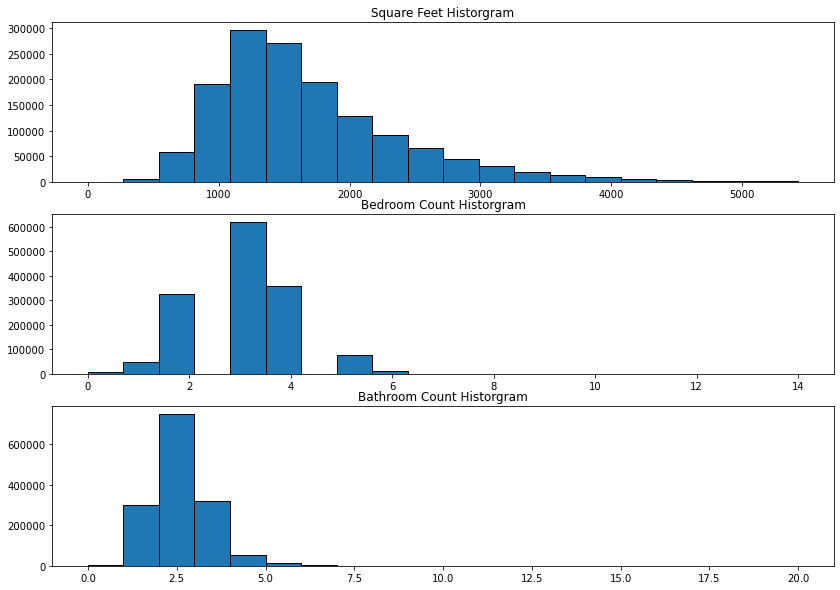

In [26]:
plt.figure(figsize = (14,10))
plt.subplot(3,1,1, title ='Square Feet Historgram')
plt.hist(data=train, x='square_feet', bins = 20, ec = 'black')

plt.subplot(3,1,2, title ='Bedroom Count Historgram')
plt.hist(data=train, x='beds', bins = 20, ec = 'black')

plt.subplot(3,1,3, title ='Bathroom Count Historgram')
plt.hist(data=train, x='baths', bins = 20, ec = 'black')

plt.show()


## showing subplot with 20 bin size to show distributions of bedrooms, bathrooms, and square feet

### Pair Plots & Heatmap

In [27]:
cols = ['square_feet', 'baths', 'beds', 'tax_value']

## setting list of columns

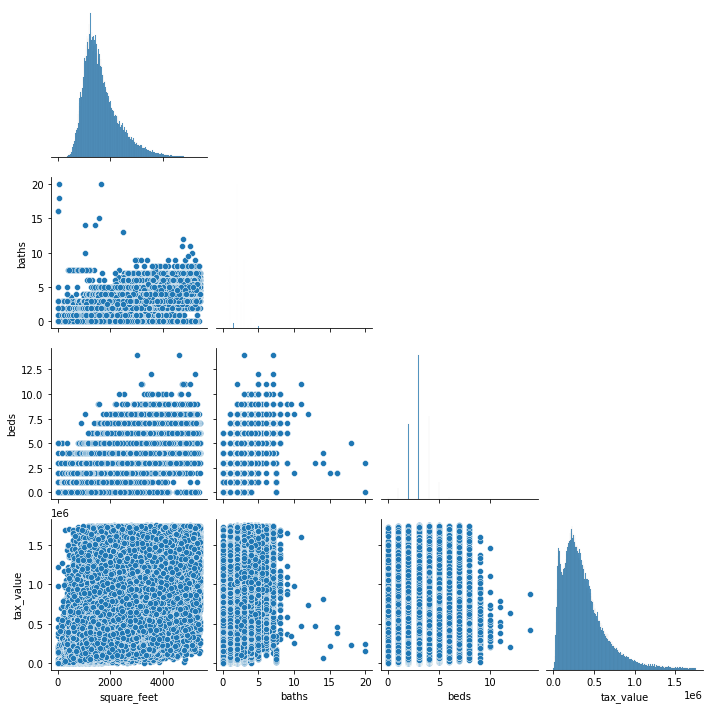

In [28]:
##creating cornered pairplot 

sns.pairplot(train[cols], corner = True)

<AxesSubplot:>

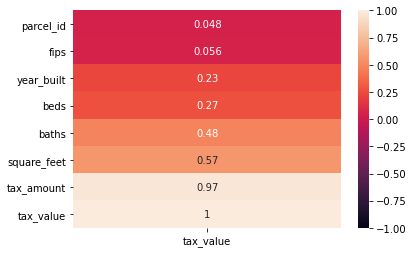

In [29]:
sns.heatmap(train.corr()[['tax_value']].sort_values(by='tax_value'), annot = True,
           vmin = -1, vmax = 1)

## Statistical Testing

In [30]:
alpha = 0.05 ## <-- Determining alpha value

#### Correlation Tests of Baths and Square_Feet

##### Standard Hypothesis for correlation test of all variables

$H_0$ : There is no relationship between these variables

$H_a$ : There is evidence to suggest there is a realtionhip between these two variables

In [31]:
## performing correlation test on square feet because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.square_feet, train.tax_value)
corr, p

(0.5658376308422073, 0.0)

 - With a high correlation of .56 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a  significant realtionship between the square feet of a single unit home and its associated tax value, thus accepting the alternate hypothesis

In [32]:
## performing correlation test on baths because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.baths, train.tax_value)
corr, p

(0.4846827914923082, 0.0)

 - With a high correlation of .48 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a  significant realtionship between the bathroom count of a single unit home and its associated tax value, thus accepting the alternate hypothesis

#### T, P Test for Square Feet and tax_value

In [33]:
null_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home"

three_or_more_beds = train[train.beds>=3]
less_than_three_beds = train[train.beds<3]
t, p = stats.ttest_ind(three_or_more_beds.tax_value, less_than_three_beds.tax_value)

if p < alpha:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home
There is evidence to suggest: Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home


In [34]:

null_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are related to value of home"
a = 0.05 #a for alpha 

three_or_more_baths = train[train.baths>=3]
less_than_three_baths = train[train.baths<3]
t, p = stats.ttest_ind(three_or_more_baths.tax_value, less_than_three_baths.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home
There is evidence to suggest: Houses with 3 bathrooms or more and houses with less than 3 bathrooms are related to value of home


## Modeling

In [35]:
## Turning all my y's into dataframe

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

### Establishing Mean and Median Baseline

In [37]:
## tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

## tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

## RMSE of tax_value_pred_mean train and validate scores
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('Baseline')
print('-----------------------------')
print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of tax_value_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

Baseline
-----------------------------
RMSE using Mean
Train/In-Sample:  281807.339 
Validate/Out-of-Sample:  281662.2611
-----------------------------
RMSE using Median
Train/In-Sample:  289571.9432 
Validate/Out-of-Sample:  289540.7683
-----------------------------
The R squared score for the baseline is -2.8815499812928635e-06


 - The mean seems to be better so we will use the mean scores to compare to out models

In [39]:
X_train_scaled.head() ## <--- taking a brief look at our scaled X columns

,beds,baths,square_feet
1947992,0.214286,0.100,0.302377
357715,0.214286,0.150,0.752718
1433502,0.285714,0.125,0.369265
195214,0.142857,0.150,0.232357
10812,0.285714,0.100,0.346969


#### LinearRegression/OLS

In [50]:
## we are going to use all three features in X scaled so no subset

## create the model
lm = LinearRegression(normalize = True)

## fit the model to train
lm.fit(X_train_scaled, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lm) **(1/2)

## predict validate 
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                y_validate.tax_value_pred_lm) **(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for OLS: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}')

RMSE for OLS using LinearRegression
Training/In-Sample:  227803.68035862283 
Validate/Out-of-Sample:  228091.73032693783
------------------------------------------------
R squared score for OLS: 0.34421269016468337


#### Lasso & Lars

In [51]:
## we are going to use all three features in X scaled so no subset

## create the model
lars = LassoLars(alpha=1.0)

## fit the model to train
lars.fit(X_train_scaled, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lars) **(1/2)

## predict validate 
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                y_validate.tax_value_pred_lars) **(1/2)

print("RMSE for Lasso & Lars \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Lasso & Lars: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)}')

RMSE for Lasso & Lars 
Training/In-Sample:  227823.53418938915 
Validate/Out-of-Sample:  228109.78283165206
------------------------------------------------
R squared score for Lasso & Lars: 0.344108880421355


#### TweedieRegressor

In [52]:
## we are going to use all three features in X scaled so no subset

## create the model
glm = TweedieRegressor(power = 0, alpha = 0)

## fit the model to train
glm.fit(X_train_scaled, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_glm) **(1/2)

## predict validate 
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_glm) **(1/2)

print("RMSE for TweedieRegressor \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for TweedieRegressor: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)}')

RMSE for TweedieRegressor 
Training/In-Sample:  227803.6803586228 
Validate/Out-of-Sample:  228091.7303269378
------------------------------------------------
R squared score for TweedieRegressor: 0.3442126901646835


#### Polynomial Regression

In [54]:
## getting new set of features using degree 4
pf = PolynomialFeatures(degree = 4)

## fitting and transforming scaled X's for lm2 below
X_train_degree2 = pf.fit_transform(X_train_scaled)
X_validate_degree2 = pf.fit_transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

#### New Linear Regression
 - Using Polynomial Features

In [56]:
## we are going to use all three features in X scaled so no subset

## create the model
lm2 = LinearRegression(normalize = True)

## fit the model to train
lm2.fit(X_train_degree2, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lm2) **(1/2)

## predict validate 
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                y_validate.tax_value_pred_lm2) **(1/2)

print("RMSE for Polynomial Features: \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Polynomial Features: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm2)}')

RMSE for Polynomial Features: 
Training/In-Sample:  226197.57119580416 
Validate/Out-of-Sample:  226569.3225652136
------------------------------------------------
R squared score for Polynomial Features: 0.35293763463352623
